# Библиотеки

In [1]:
import pandas as pd # Чтение даатасета
import numpy as np # Вспомогательная библиотека
import seaborn as sns # Для отображения библиотек
import matplotlib.pyplot as plt
import scipy.stats as stats # Статистики
from sklearn.linear_model import LinearRegression # Линейная регрессия

from pathlib import Path # Удобный менеджмент файлов

# Данные

In [2]:
folder = Path('../data')

In [3]:
dataset_gdp = pd.read_csv(str(folder / 'data_gdp.csv'))
dataset_gdp = (
    dataset_gdp[dataset_gdp['Country Code'] == 'MDG'] # Только нужная страна
    .drop(columns=['Country Name', 'Indicator Name', 'Indicator Code', 'Unnamed: 68', 'Country Code']) # Убираем ненужные колонки
    .dropna(axis=1) # Не нужны пустые значения
    .reset_index(drop=True) # Для удобного отображения
    .T # В удобный формат таблички
    .rename(columns={0: 'GDP'}) # Переименовали табличку
)
dataset_gdp.head()

,GDP
1960,6.730817e+08
1961,6.991619e+08
1962,7.392869e+08
1963,7.593459e+08
1964,8.024822e+08


In [4]:
dataset_unemployment = pd.read_csv(str(folder / 'data_unemployment.csv'))
dataset_unemployment = (
    dataset_unemployment[dataset_unemployment['Country Code'] == 'MDG'] # Только нужная страна
    .drop(columns=['Country Name', 'Indicator Name', 'Indicator Code', 'Unnamed: 68', 'Country Code']) # Убираем ненужные колонки
    .dropna(axis=1) # Не нужны пустые значения
    .reset_index(drop=True) # Для удобного отображения
    .T # В удобный формат таблички
    .rename(columns={0: 'Unemp'}) # Переименовали табличку
)
dataset_unemployment.head()

,Unemp
1991,6.140
1992,6.251
1993,6.300
1994,6.090
1995,6.078


<div class="alert alert-info">

Обрежем ВВП страны, начиная с 1991, так как уровень безработицы известен только именно с этого года 

In [5]:
dataset_gdp = dataset_gdp.iloc[1991-1960:]

# ВВП и Безработица в Мадагаскаре

<div class="alert alert-success">

Объединим все в один датасет для лучшего отображения

In [6]:
dataset = (
    dataset_gdp.join(dataset_unemployment) # Объединяем
    .reset_index().rename(columns={'index': 'Year'}) # Год, как отдельный признак
)
dataset['GDP'] = dataset['GDP'] / 1e9 # Масштабируем признак, чтобы ВВП было в миллиардах

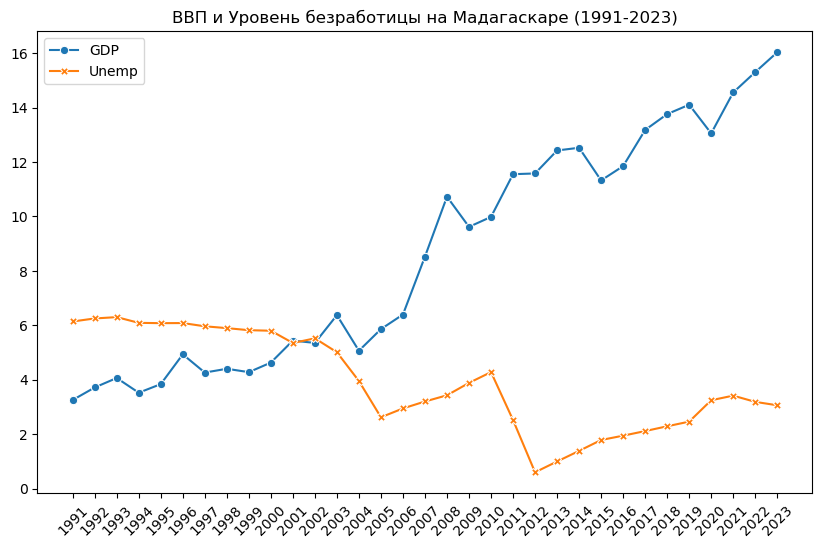

In [7]:
plt.figure(figsize=(10, 6), dpi=100)
plt.title('ВВП и Уровень безработицы на Мадагаскаре (1991-2023)')

g = sns.lineplot(
    data=dataset,
    markers=True,
    dashes=False,
)

g = g.set_xticks(range(len(dataset)), labels=dataset['Year'].to_list(), rotation=45)
plt.show(g)

<div class="alert alert-warning">

Из анализа графика видно, что данные о ВВП и уровне безработицы до 2002 года не оказывают значительного влияния на общий результат.  
В этот период наблюдается прямая пропорциональная зависимость между ростом ВВП и уровнем безработицы, что указывает на то, что эти данные могут быть исключены из дальнейшего анализа.  
С 2002 года тенденции начинают изменяться, и их влияние на экономические показатели становится более выраженным.

# Расчет корреляции

In [8]:
gdp = dataset['GDP'].to_numpy()
unemployment = dataset['Unemp'].to_numpy()
n = len(gdp)

In [9]:
gamma, p_value  = stats.pearsonr(unemployment, gdp)
print(f'Коэффицент корреляции: {gamma}')

t_rasch = stats.t.ppf(1 - p_value / 2, n - 2)
print(f'Расчетное распределение стъюдента: {t_rasch}')

alpha = 0.05
t_tabl = stats.t.ppf(1 - alpha / 2, n - 2)
print(f'Табличное распределение стъюдента: {t_tabl}')

Коэффицент корреляции: -0.8078144483004173
Расчетное распределение стъюдента: 7.630538178284982
Табличное распределение стъюдента: 2.0395134463964077


<div class="alert alert-success">

* Наблюдается сильная обратная связь $\approx -0.8$
* $t_{\text{расч}} > t_{\text{табл}}$. Значит корреляция значима 

# Линейная регрессия

In [10]:
model = LinearRegression()

In [11]:
X = unemployment.reshape((-1, 1))
y = gdp.reshape((-1, 1))

In [12]:
model.fit(X, y)

LinearRegression()

In [13]:
model.coef_.ravel()[0]

-1.9053838542786112

In [14]:
model.intercept_.ravel()[0]

16.13347213771032

In [15]:
y_pred = model.predict(X)

In [16]:
S = (np.sum((y - y_pred)**2) / (n - 2))**0.5 # std регрессии
S

2.510694677973598

In [17]:
S_b0 = S * (np.sum(X**2) / (n * np.sum((X - X.mean())**2)))**0.5
S_b0

1.0736716536693918

In [18]:
S_b1 = S * (1 / np.sum((X - X.mean())**2))**0.5
S_b1

0.24970504176335678

In [19]:
t_rasch_b0 = model.intercept_.ravel()[0] / S_b0
t_rasch_b0, t_tabl

(15.026448805435436, 2.0395134463964077)

In [20]:
t_rasch_b1 =  model.coef_.ravel()[0] / S_b1
abs(t_rasch_b1), t_tabl

(7.63053817745629, 2.0395134463964077)

<div class="alert">

$b0_{\text{расч}} > b0_{\text{табл}}; b1_{\text{расч}} > b1_{\text{табл}}$ => $b0$ и $b1$ статистически значимы

# Значимость уравнения

In [21]:
alpha = 0.95
nu_1 = 1
F_tabl = stats.f.ppf(alpha, nu_1, n - 2)

In [22]:
F_rasch = (n - 2)*gamma**2 / (1 - gamma**2)
F_rasch, F_tabl

(58.22511287761794, 4.159615098031756)

$F_{\text{расч}} > F_{\text{табл}}$ => ур-е значимо

# График уравнения

In [23]:
X_test = np.linspace(X.min(), X.max(), 1_000).reshape((-1, 1))
y_test = model.predict(X_test)

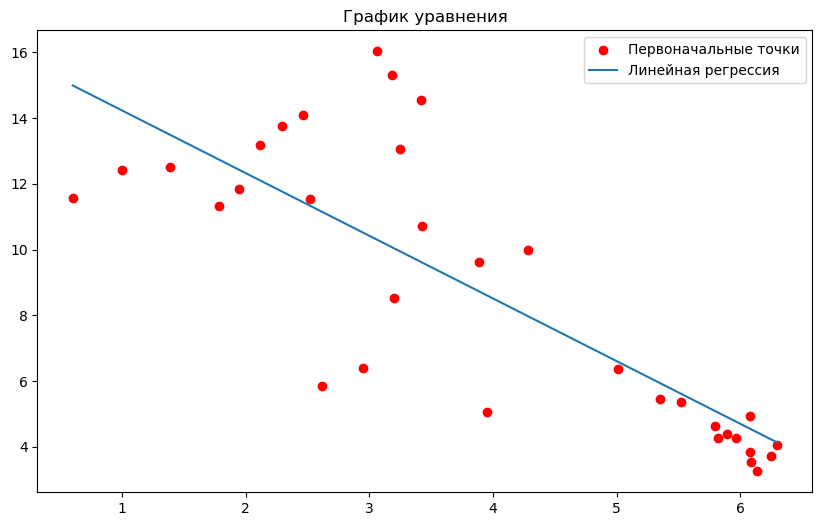

In [24]:
plt.figure(figsize=(10, 6), dpi=100)
plt.title('График уравнения')
plt.scatter(X, y, c='r', label='Первоначальные точки')
plt.plot(X_test, y_test, label='Линейная регрессия')
plt.legend()
plt.show()

In [25]:
model.score(X, y)

0.6525641828829074

# Расчет коэффициента Оукена

In [26]:
normal_gdp = 2.5

In [27]:
dataset['GDP increase rate'] = round(dataset['GDP'].pct_change(periods=1) * 100, 3)
dataset['Unemployment diff'] = dataset['Unemp'].diff(periods=1)
dataset['Ouken coefficient'] = -1 * dataset['Unemployment diff'] / (dataset['GDP increase rate'] - normal_gdp)

In [28]:
dataset['mean Ouken coefficient'] = dataset['Ouken coefficient'].mean()
dataset['mean Ouken coefficient'][0]

-1.0891759323695764

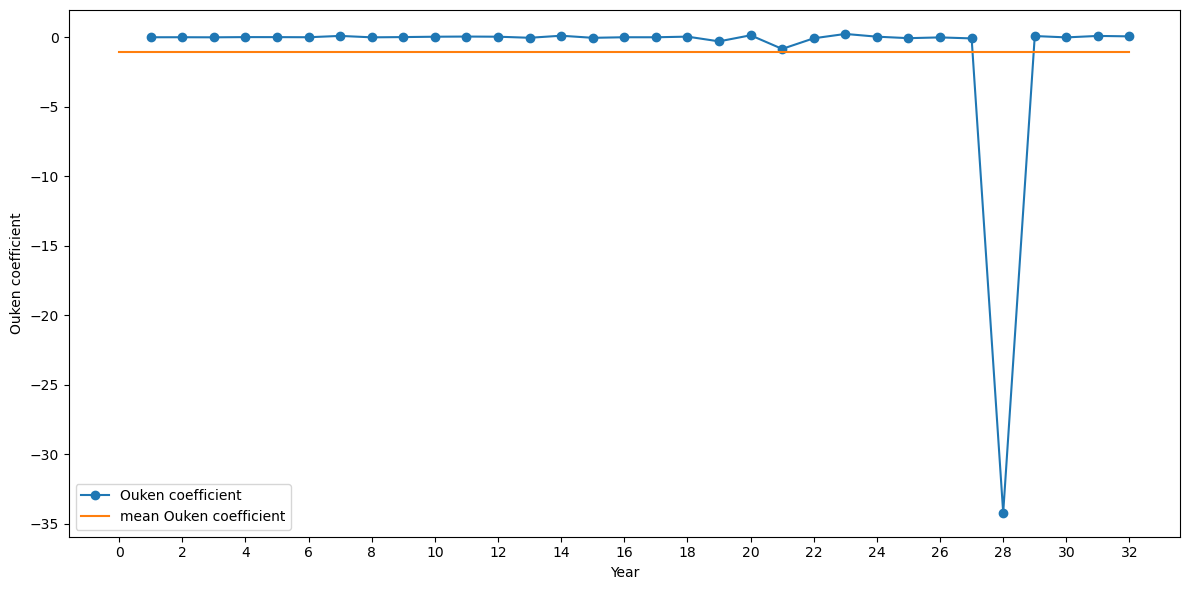

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(dataset['Ouken coefficient'], marker='o', label='Ouken coefficient')
ax.plot(dataset['mean Ouken coefficient'], label='mean Ouken coefficient')
ax.set_xticks(dataset.index[::2])
ax.set_ylabel('Ouken coefficient')
ax.set_xlabel('Year')
ax.legend()
fig.tight_layout()

plt.show()